In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random

random.seed(42)

big_dataset = pd.read_csv("feature_with_ALH_with_lat_lon.csv", index_col=0)

with_MODIS_mask = ~np.isnan(big_dataset["MODIS_AOD"]) & ~np.isinf(big_dataset["MODIS_AOD"])
print(f"with MODIS count: {np.sum(with_MODIS_mask)}")

modis_dataset = big_dataset[with_MODIS_mask]

train_dataset, test_dataset = train_test_split(big_dataset, test_size=0.2, random_state=42)

modis_train_dataset, modis_test_dataset = train_test_split(modis_dataset, test_size=0.2, random_state=42)

X_train_modis = modis_train_dataset.drop(['ALH_CALIPSO', 'MODIS_AOD', 'COD_CALIPSO', 'AOD_OCO', 'AOD_CALIPSO', 'OCO_latitude', 'OCO_longitude', 'CALIPSO_latitude', 'CALIPSO_longitude', 'MODIS_latitude', 'MODIS_longitude'], axis=1)
X_test_modis = modis_test_dataset.drop(['ALH_CALIPSO', 'MODIS_AOD', 'COD_CALIPSO', 'AOD_OCO', 'AOD_CALIPSO', 'OCO_latitude', 'OCO_longitude', 'CALIPSO_latitude', 'CALIPSO_longitude', 'MODIS_latitude', 'MODIS_longitude'], axis=1)

X_train = train_dataset.drop(['ALH_CALIPSO', 'MODIS_AOD', 'COD_CALIPSO', 'AOD_OCO', 'AOD_CALIPSO', 'OCO_latitude', 'OCO_longitude', 'CALIPSO_latitude', 'CALIPSO_longitude', 'MODIS_latitude', 'MODIS_longitude'], axis=1)
X_test = test_dataset.drop(['ALH_CALIPSO', 'MODIS_AOD', 'COD_CALIPSO', 'AOD_OCO', 'AOD_CALIPSO', 'OCO_latitude', 'OCO_longitude', 'CALIPSO_latitude', 'CALIPSO_longitude', 'MODIS_latitude', 'MODIS_longitude'], axis=1)


y_train_calipso = (train_dataset["AOD_CALIPSO"])
y_test_calipso = (test_dataset["AOD_CALIPSO"])

sc = MinMaxScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)

X_train

In [48]:
modis_sc = MinMaxScaler()
X_train_modis = pd.DataFrame(modis_sc.fit_transform(X_train_modis), columns = X_train_modis.columns)
X_test_modis = pd.DataFrame(modis_sc.transform(X_test_modis), columns = X_test_modis.columns)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(13,)))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu')),
model.add(tf.keras.layers.Dense(units=32, activation='relu')),
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=8, activation='relu'))
model.add(tf.keras.layers.Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dense(units=1))

model.compile(optimizer='adam', loss='mse')

model.summary()

history = model.fit(X_train, y_train_calipso, validation_split=.1,  epochs=3000)

In [ ]:
model.save("CALIPSO_AOD_MODEL.keras")

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
pred = model.predict(X_test).flatten()
pred

In [ ]:
def plot_scatter(
    X,
    Y,
    dataset_name,
    feature_name,
    x_label=None,
    y_label=None,
    x_log=True,
    y_log=True,
):
    import matplotlib.pyplot as plt
    
    nan_mask = np.logical_or(np.isnan(X), np.isnan(Y))
    X = X[~nan_mask]
    Y = Y[~nan_mask]

    if x_log:
        X = np.exp(X)
    if y_log:
        Y = np.exp(Y)
    # print(Y.min(), Y.max())

    if x_label is None:
        x_label = f"CALIPSO {feature_name}"
    if y_label is None:
        y_label = f"OCO ML Predict {feature_name}"

    LIMIT = 3.0
    plt.figure(figsize=(5, 5))
    plt.scatter(X, Y, s=2, c="b", alpha=0.1)
    plt.plot([0, 10], [0, 10], ls="--", c=".3")
    # calc and plot correlation coefficient
    mask = np.logical_and(X > 0, Y > 0)
    corr = np.corrcoef(X[mask], Y[mask])[0, 1]
    plt.text(0.05, 0.95, f"Corr: {corr:.6f}", transform=plt.gca().transAxes)

    lim = min(LIMIT, max(X.max(), Y.max()))
    plt.xlim(0, min(LIMIT, lim))
    plt.ylim(0, min(LIMIT, lim))
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.savefig(f"{dataset_name}_{feature_name}.png")

plot_scatter(y_test_calipso, pred, "CALIPSO", "AOD")

train_pred = model.predict(X_train).flatten()

plot_scatter(y_train_calipso, train_pred, "CALIPSO", "AOD")

In [ ]:
y_train_calipso_tod = np.log(np.exp(train_dataset["AOD_CALIPSO"] + np.exp(train_dataset["COD_CALIPSO"])))


tod_model = tf.keras.Sequential()
tod_model.add(tf.keras.layers.Input(shape=(13,)))
tod_model.add(tf.keras.layers.Dense(units=128, activation='relu'))
tod_model.add(tf.keras.layers.Dense(units=64, activation='relu')),
tod_model.add(tf.keras.layers.Dense(units=32, activation='relu')),
tod_model.add(tf.keras.layers.Dense(units=16, activation='relu'))
tod_model.add(tf.keras.layers.Dense(units=8, activation='relu'))
tod_model.add(tf.keras.layers.Dense(units=4, activation='relu'))
tod_model.add(tf.keras.layers.Dense(units=1))

tod_model.compile(optimizer='adam', loss='mse')

tod_model.summary()

history_tod = tod_model.fit(X_train, y_train_calipso_tod, validation_split=.1,  epochs=3000)
tod_model.save("CALIPSO_TOD_MODEL.keras")

In [ ]:
y_train_modis_aod = modis_train_dataset["MODIS_AOD"]


modis_model = tf.keras.Sequential()
modis_model.add(tf.keras.layers.Input(shape=(13,)))
modis_model.add(tf.keras.layers.Dense(units=128, activation='relu'))
modis_model.add(tf.keras.layers.Dense(units=64, activation='relu')),
modis_model.add(tf.keras.layers.Dense(units=32, activation='relu')),
modis_model.add(tf.keras.layers.Dense(units=16, activation='relu'))
modis_model.add(tf.keras.layers.Dense(units=8, activation='relu'))
modis_model.add(tf.keras.layers.Dense(units=4, activation='relu'))
modis_model.add(tf.keras.layers.Dense(units=1))

modis_model.compile(optimizer='adam', loss='mse')

modis_model.summary()

history_modis = modis_model.fit(X_train_modis, y_train_modis_aod, validation_split=.1,  epochs=3000)
modis_model.save("MODIS_AOD_MODEL.keras")

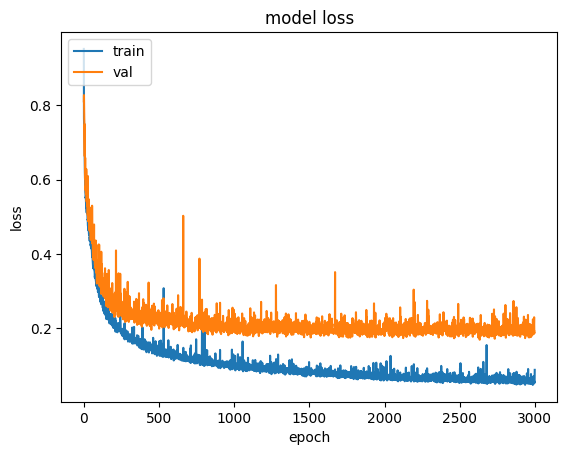

In [46]:
plt.plot(history_modis.history['loss'])
plt.plot(history_modis.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


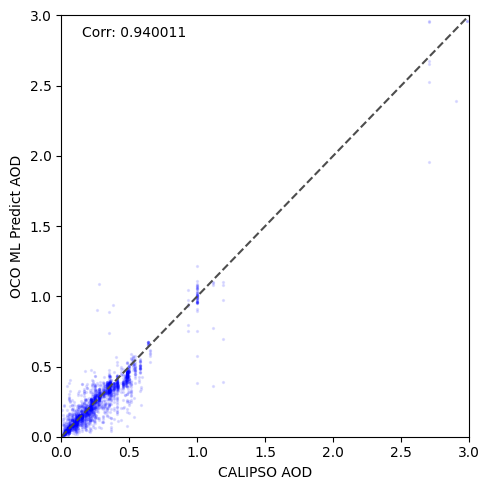

In [47]:
modis_pred = modis_model.predict(X_test_modis).flatten()
y_test_modis = modis_test_dataset["MODIS_AOD"]

plot_scatter(y_test_modis, modis_pred, "MODIS", "AOD")


In [ ]:
y_train_calipso_alh = train_dataset["ALH_CALIPSO"]

alh_model = tf.keras.Sequential()
alh_model.add(tf.keras.layers.Input(shape=(13,)))
alh_model.add(tf.keras.layers.Dense(units=128, activation='relu'))
alh_model.add(tf.keras.layers.Dense(units=64, activation='relu')),
alh_model.add(tf.keras.layers.Dense(units=32, activation='relu')),
alh_model.add(tf.keras.layers.Dense(units=16, activation='relu'))
alh_model.add(tf.keras.layers.Dense(units=8, activation='relu'))
alh_model.add(tf.keras.layers.Dense(units=4, activation='relu'))
alh_model.add(tf.keras.layers.Dense(units=1))

alh_model.compile(optimizer='adam', loss='mse')

alh_model.summary()

alh_history = model.fit(X_train, y_train_calipso, validation_split=.1,  epochs=3000)
alh_model.save("CALIPSO_ALH_MODEL.keras")

In [ ]:
import joblib
joblib.dump(sc, 'scaler.gz')